<a href="https://colab.research.google.com/github/miladasgari178/Drift_Detection_Machine_Learning/blob/main/Drift_Detection_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import inv
import math
import re
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/shiam/'
df = pd.read_csv('20160930_203718.csv')
df.head(500)

Mounted at /content/gdrive
/content/gdrive/My Drive/shiam


,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
0,0.000,0.0,49.7534,23.7184,233.2737,0.8993,0.2231,0.6365,1.1493,0.8483,1.2534,1.4449,1.9906,1.3303,1.4480,1.9148,3.4651,5.2144,6.5806,8.6385
1,0.309,0.0,55.8400,26.6200,241.6323,0.2112,2.1314,5.3552,9.7569,6.3188,9.4472,10.5769,13.6317,21.9829,16.1902,24.2780,31.1014,34.7193,31.7505,41.9167
2,0.618,0.0,55.8400,26.6200,241.3888,0.2070,10.5318,22.5612,37.2635,17.7848,33.0704,36.3160,42.5746,49.7495,31.7533,57.7289,53.6275,56.9212,47.8255,62.9436
3,0.926,0.0,55.8400,26.6200,241.1461,0.2042,29.5749,49.5111,65.6318,26.1447,58.3847,67.5130,68.0064,59.2824,36.7821,66.0832,66.8349,66.9695,50.3730,64.8363
4,1.234,0.0,55.8400,26.6200,240.9121,0.2030,49.5111,67.0368,77.8317,27.9625,71.7732,79.9474,79.8631,62.5385,39.6271,68.1441,62.0947,49.4614,52.8453,66.8445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,152.570,0.0,54.3300,26.5800,240.3827,0.1990,0.4607,0.5501,0.7433,5.3947,6.2541,3.7358,5.1647,36.1896,28.0132,40.4326,47.7312,36.4956,31.7505,47.2945
496,152.880,0.0,54.3300,26.5800,240.2346,0.2000,0.4537,0.5443,0.7291,5.0777,5.7716,3.5085,4.7817,37.7252,28.0132,40.6416,44.7674,35.7480,31.7505,47.0102
497,153.189,0.0,54.3300,26.5800,240.0869,0.2000,0.4472,0.5385,0.7151,4.8117,5.3664,3.3301,4.4760,39.6076,27.4403,40.6416,43.6563,36.3548,31.8817,48.0691
498,153.498,0.0,54.3300,26.5800,240.0243,0.1995,0.4411,0.5339,0.7026,4.5651,4.9990,3.1616,4.1594,35.6850,27.6287,39.6838,47.2109,35.1605,31.1729,47.0102


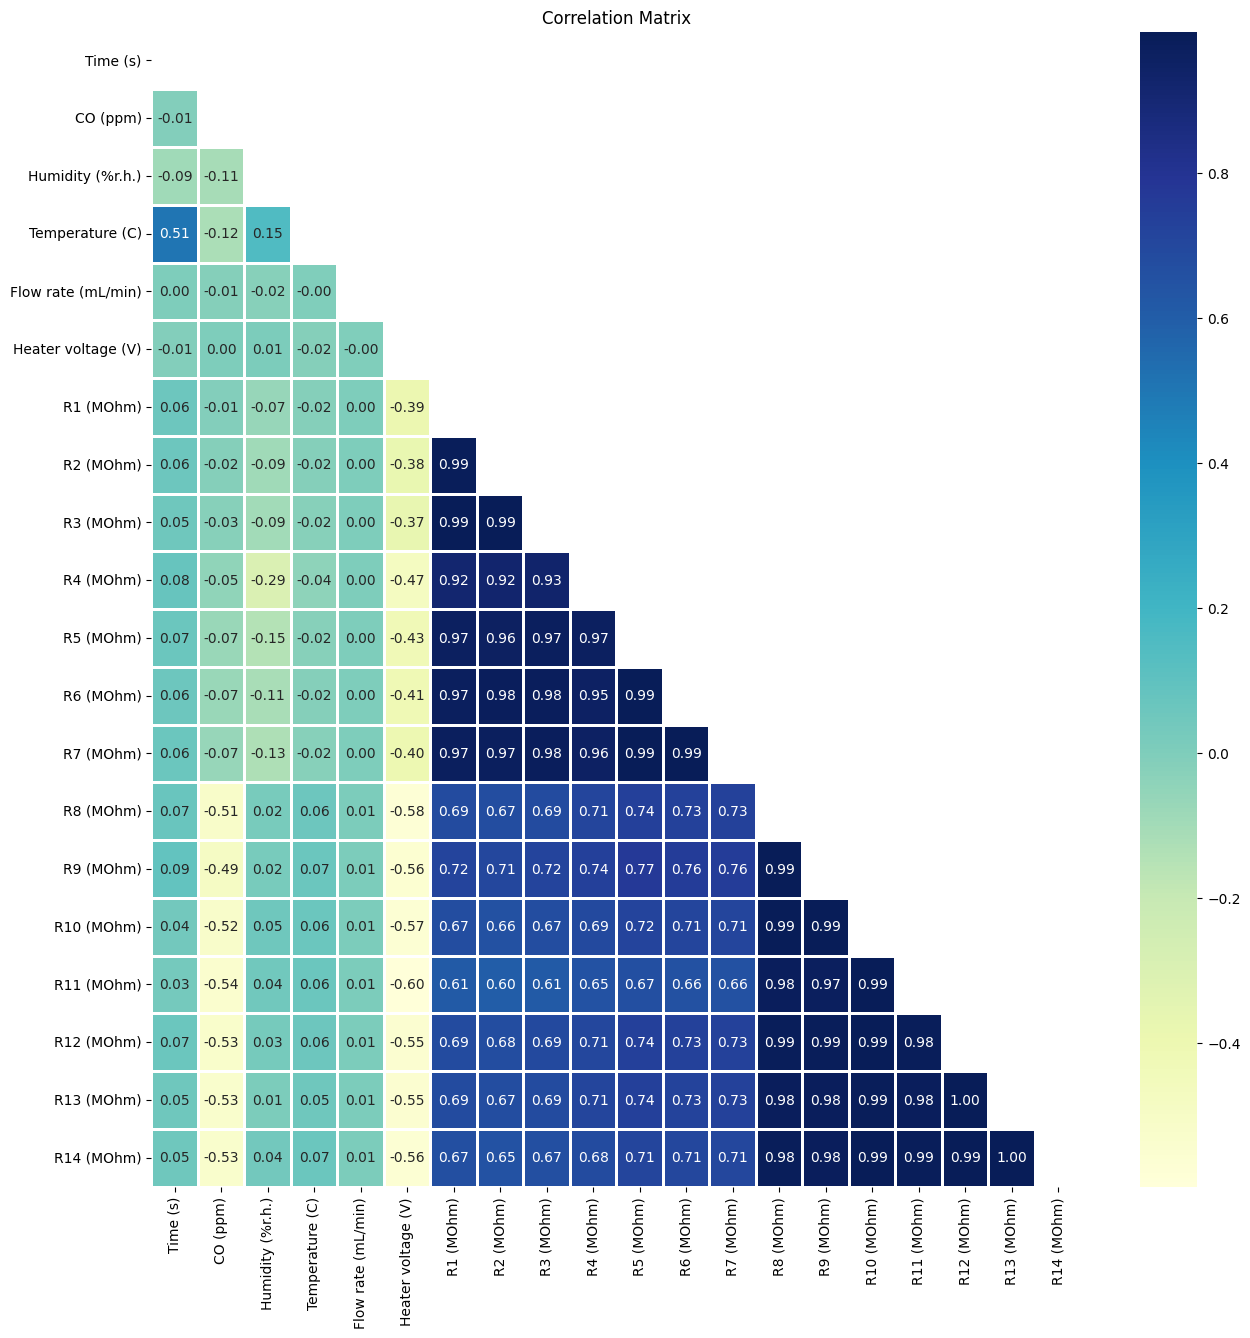

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
corr = df.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
cormat = sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', linewidths=1, fmt=".2f")
cormat.set_title('Correlation Matrix')
plt.show()

In [ ]:
CO_value = 20
humidity_value = 22.0000
heater_value = 0.2000
temperature_value = 26.62

In [ ]:
filter_conditions = (df['CO (ppm)'] == CO_value) & (df['Heater voltage (V)'] == heater_value) & (df['Humidity (%r.h.)'] == humidity_value)

In [ ]:
# Filter the dataset based on the conditions
df_temp = df[filter_conditions]
df_temp.head()

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
276926,85127.182,20.0,22.0,26.62,239.9580,0.2,25.3114,29.5749,47.0683,40.0709,55.0376,52.1297,53.0601,19.6560,15.4712,14.4402,17.9574,18.8257,14.2435,18.4191
276927,85127.492,20.0,22.0,26.62,239.9664,0.2,22.2642,24.8607,42.6608,37.7935,53.3824,50.4951,53.3574,20.0712,15.1969,14.4933,17.4917,18.8257,14.1173,18.2967
276928,85127.802,20.0,22.0,26.62,239.9782,0.2,18.6722,20.7507,39.3194,38.8066,54.0448,48.4314,50.5778,19.5091,14.9263,14.1245,16.5264,18.2358,13.9659,17.8442
276929,85128.111,20.0,22.0,26.62,239.9899,0.2,15.9485,16.7138,34.4177,36.8645,50.8849,47.8646,51.7898,19.5091,14.6698,14.0009,17.4574,18.1987,13.8174,17.6861
276930,85128.421,20.0,22.0,26.62,240.0061,0.2,13.1638,13.4137,29.9089,36.3021,48.8555,45.2150,49.6787,19.3553,14.4164,13.5389,17.3078,17.8354,13.6458,17.3435


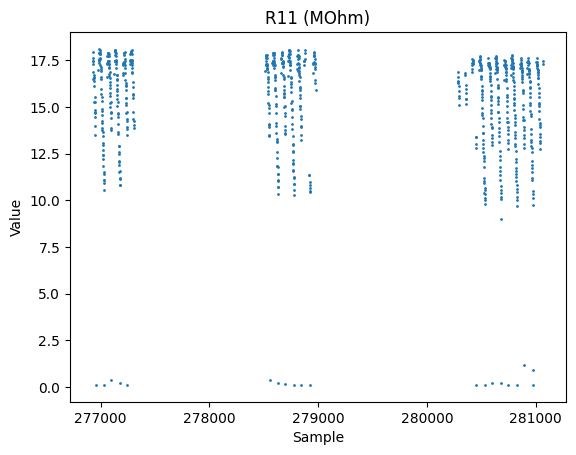

In [ ]:
for col in df_temp.columns[16:17]:
    # Create a scatter plot for the column
    plt.scatter(df_temp.index, df_temp[col], s=1)
    plt.title(col)
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.show()

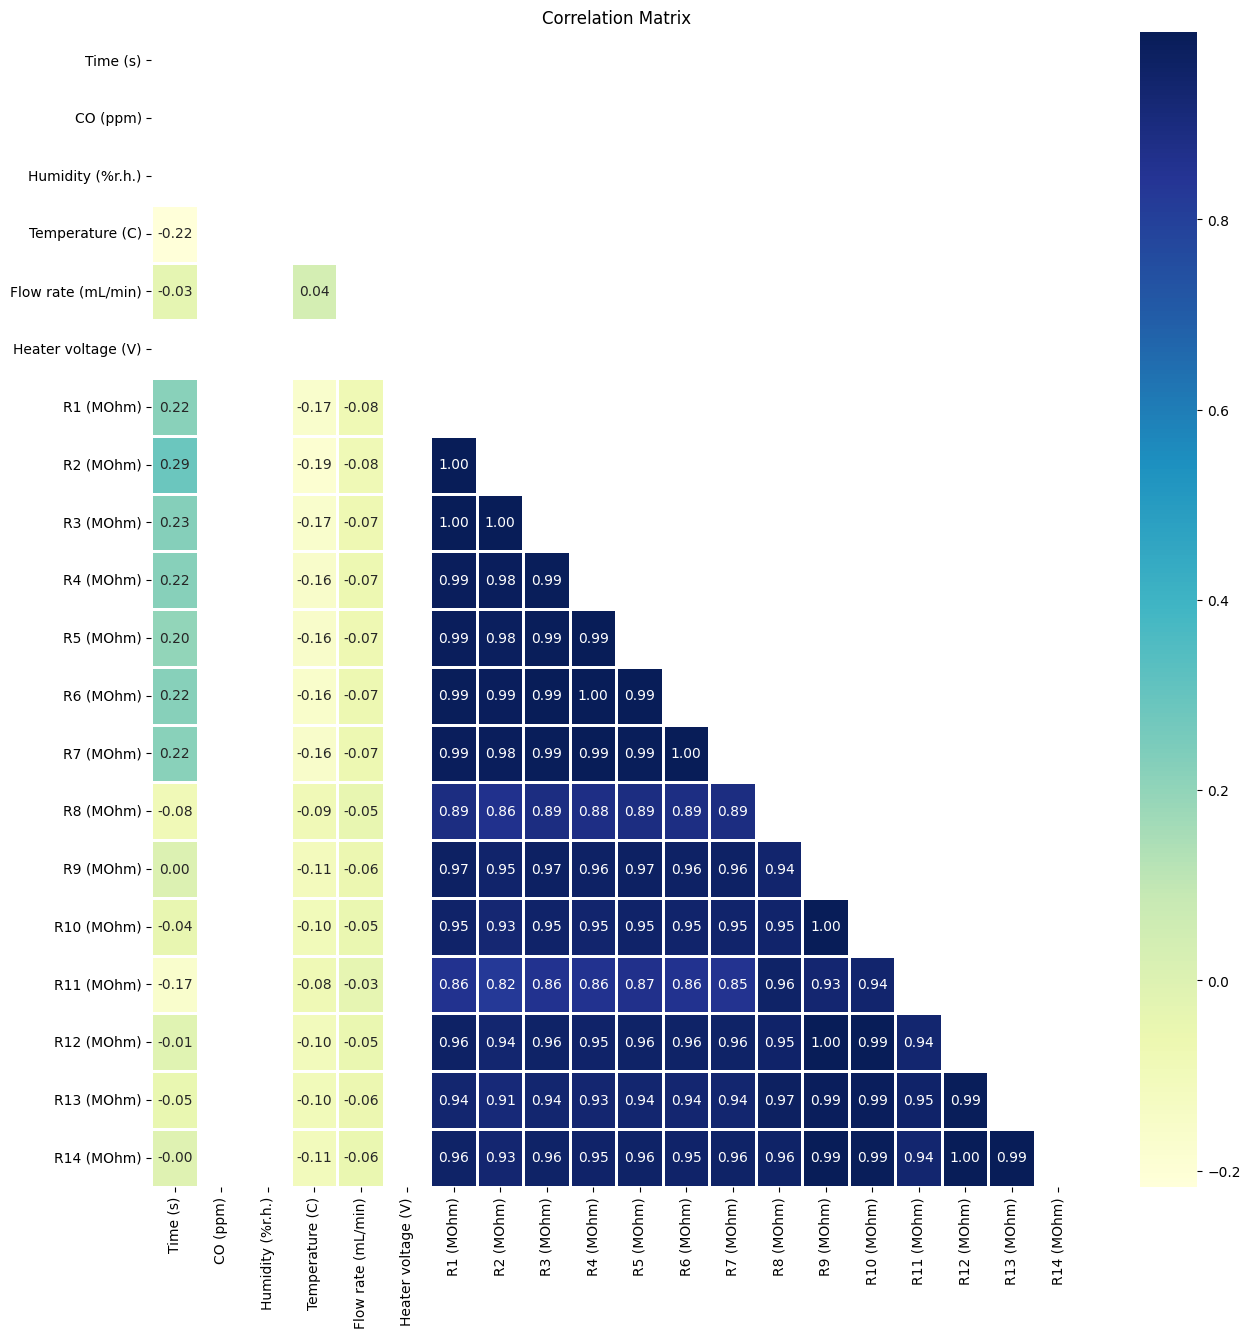

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
corr = df_temp.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
cormat = sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', linewidths=1, fmt=".2f")
cormat.set_title('Correlation Matrix')
plt.show()

In [ ]:
class SensorDriftDetector:
    def __init__(self, A, H, Q, R, x0, P0):
        self.A = A
        self.H = H
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0

    def predict(self):
        # Predict the state estimate and error covariance estimate
        x_pred = self.A @ self.x
        P_pred = self.A @ self.P @ self.A.T + self.Q

        return x_pred, P_pred

    def update(self, z):
        # Compute the Kalman gain
        K = self.P @ self.H.T @ inv(self.H @ self.P @ self.H.T + self.R)

        # Update the state estimate and error covariance estimate
        self.x = self.x + K @ (z - self.H @ self.x)
        self.P = (np.eye(len(self.x)) - K @ self.H) @ self.P

    def detect_drift(self, z):
        # Predict the state estimate and error covariance estimate
        x_pred, P_pred = self.predict()

        # Update the state estimate and error covariance estimate
        self.update(z)

        # Compute the residual
        residual = z - self.H @ x_pred
        return np.linalg.norm(residual), self.H @ x_pred

In [ ]:
# Define the Kalman filter parameters
dt = 0.3  # time step
A = np.array([[1, dt], [0, 1]])  # state transition matrix
H = np.array([[1, 0]])  # observation matrix
Q = np.array([[1e-3, 0], [0, 1e-3]])  # process noise covariance matrix
R = np.array([[1e-1]])  # measurement noise covariance matrix
x0 = np.array([[0], [0]])  # initial state estimate
P0 = np.array([[1, 0], [0, 1]])  # initial error covariance estimate

# Create the Kalman filter object
kalman_filter = SensorDriftDetector(A, H, Q, R, x0, P0)

predicted_value = []
measured_value = []
# Loop over the rows of the dataset
for i in range(len(df_temp)):
    # Get the sensor measurement vector
    z = np.array(df_temp.iloc[i, 16:17])
    # Detect drift using the Kalman filter
    residual, predicted = kalman_filter.detect_drift(z)
    predicted_value.append(float(predicted))
    measured_value.append(z)

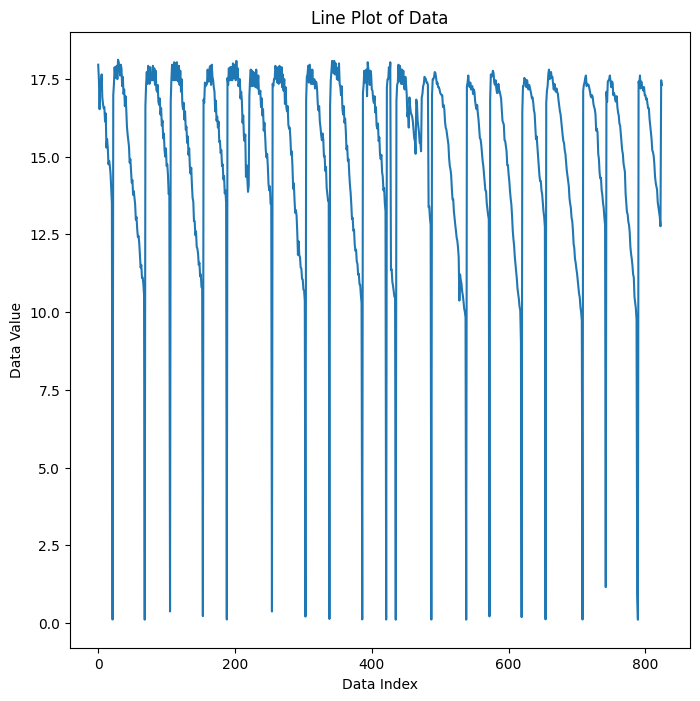

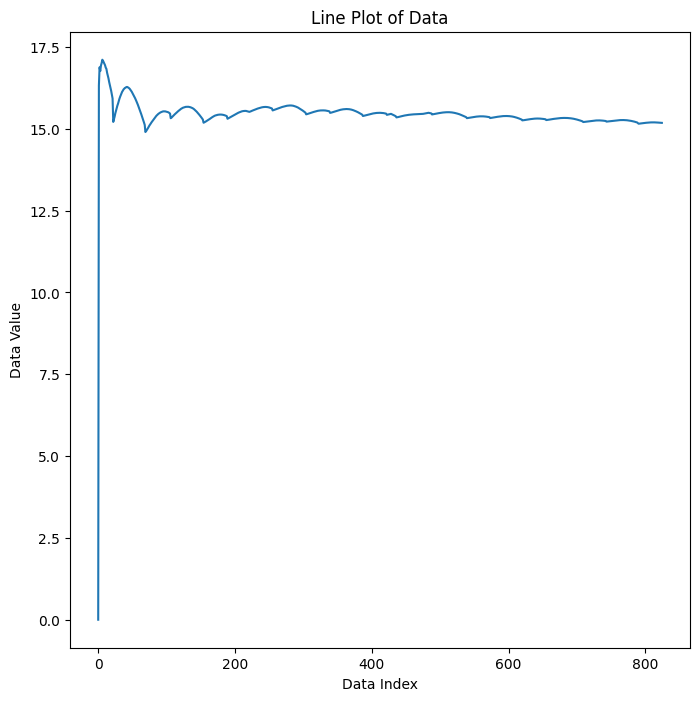

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(measured_value)
ax.set_xlabel('Data Index')
ax.set_ylabel('Data Value')
ax.set_title('Line Plot of Data')
plt.show()

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(predicted_value)
ax.set_xlabel('Data Index')
ax.set_ylabel('Data Value')
ax.set_title('Line Plot of Data')
plt.show()

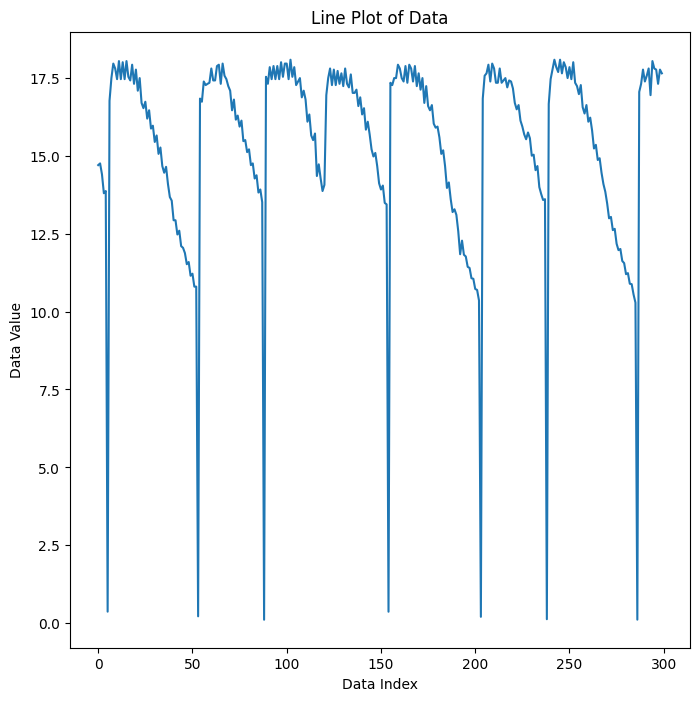

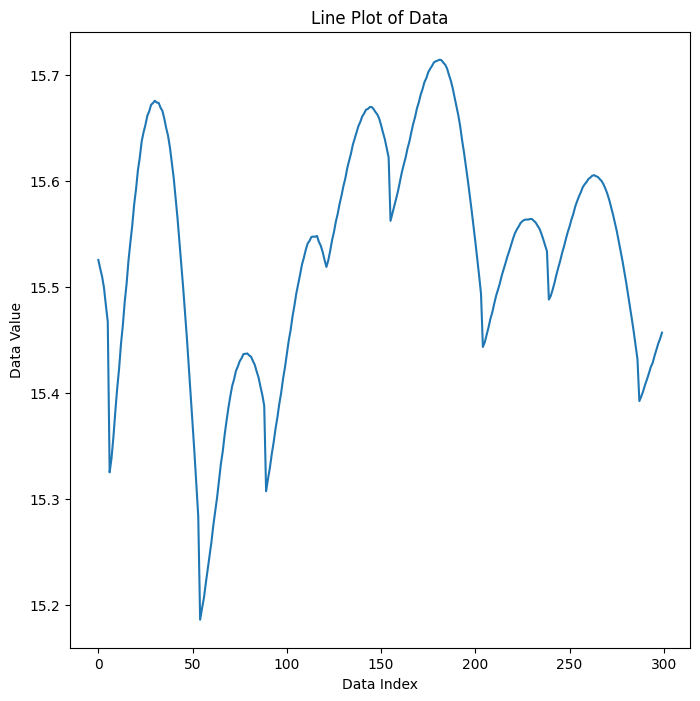

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(measured_value[100:400])
ax.set_xlabel('Data Index')
ax.set_ylabel('Data Value')
ax.set_title('Line Plot of Data')
plt.show()

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(predicted_value[100:400])
ax.set_xlabel('Data Index')
ax.set_ylabel('Data Value')
ax.set_title('Line Plot of Data')
plt.show()

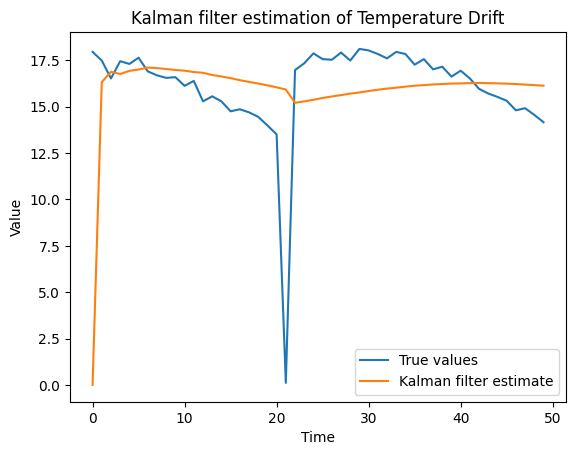

In [ ]:
t = np.arange(0, 50, 1)
plt.plot(t, measured_value[0:50], label='True values')
plt.plot(t, predicted_value[0:50], label='Kalman filter estimate')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Kalman filter estimation of Temperature Drift')


plt.show()

In [ ]:
# Count the occurrences of each unique value in a specific column
value_counts = df['Temperature (C)'].value_counts()

# Print the value counts
print(value_counts)

26.2200    28561
26.3800    25146
26.5800    24406
26.4600    21398
26.7800    20200
           ...  
26.3311        1
26.3056        1
26.3300        1
26.3284        1
26.5846        1
Name: Temperature (C), Length: 5625, dtype: int64


In [ ]:
filter_heater = (df['CO (ppm)'] == CO_value) & (df['Temperature (C)'] == temperature_value) & (df['Humidity (%r.h.)'] == humidity_value)

In [ ]:
# Filter the dataset based on the conditions
df_heater = df[filter_heater]
df_heater.head()

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
276926,85127.182,20.0,22.0,26.62,239.9580,0.2,25.3114,29.5749,47.0683,40.0709,55.0376,52.1297,53.0601,19.6560,15.4712,14.4402,17.9574,18.8257,14.2435,18.4191
276927,85127.492,20.0,22.0,26.62,239.9664,0.2,22.2642,24.8607,42.6608,37.7935,53.3824,50.4951,53.3574,20.0712,15.1969,14.4933,17.4917,18.8257,14.1173,18.2967
276928,85127.802,20.0,22.0,26.62,239.9782,0.2,18.6722,20.7507,39.3194,38.8066,54.0448,48.4314,50.5778,19.5091,14.9263,14.1245,16.5264,18.2358,13.9659,17.8442
276929,85128.111,20.0,22.0,26.62,239.9899,0.2,15.9485,16.7138,34.4177,36.8645,50.8849,47.8646,51.7898,19.5091,14.6698,14.0009,17.4574,18.1987,13.8174,17.6861
276930,85128.421,20.0,22.0,26.62,240.0061,0.2,13.1638,13.4137,29.9089,36.3021,48.8555,45.2150,49.6787,19.3553,14.4164,13.5389,17.3078,17.8354,13.6458,17.3435


In [ ]:
# Define the Kalman filter parameters
dt = 0.3  # time step
A = np.array([[1, dt], [0, 1]])  # state transition matrix
H = np.array([[1, 0]])  # observation matrix
Q = np.array([[1e-3, 0], [0, 1e-3]])  # process noise covariance matrix
R = np.array([[1e-1]])  # measurement noise covariance matrix
x0 = np.array([[0], [0]])  # initial state estimate
P0 = np.array([[1, 0], [0, 1]])  # initial error covariance estimate

# Create the Kalman filter object
kalman_filter = SensorDriftDetector(A, H, Q, R, x0, P0)

predicted_value = []
measured_value = []
# Loop over the rows of the dataset
for i in range(len(df_heater)):
    # Get the sensor measurement vector
    z = np.array(df_heater.iloc[i, 16:17])
    # Detect drift using the Kalman filter
    residual, predicted = kalman_filter.detect_drift(z)
    predicted_value.append(float(predicted))
    measured_value.append(z)

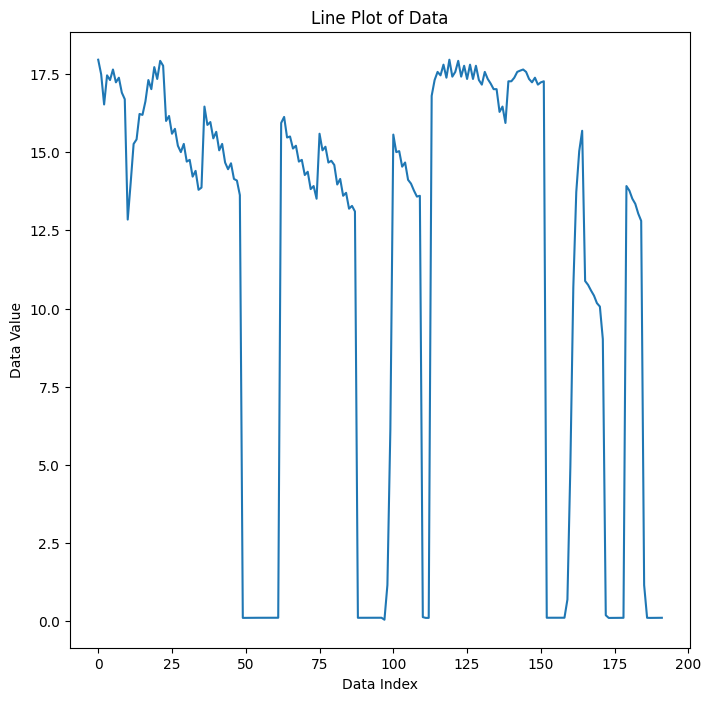

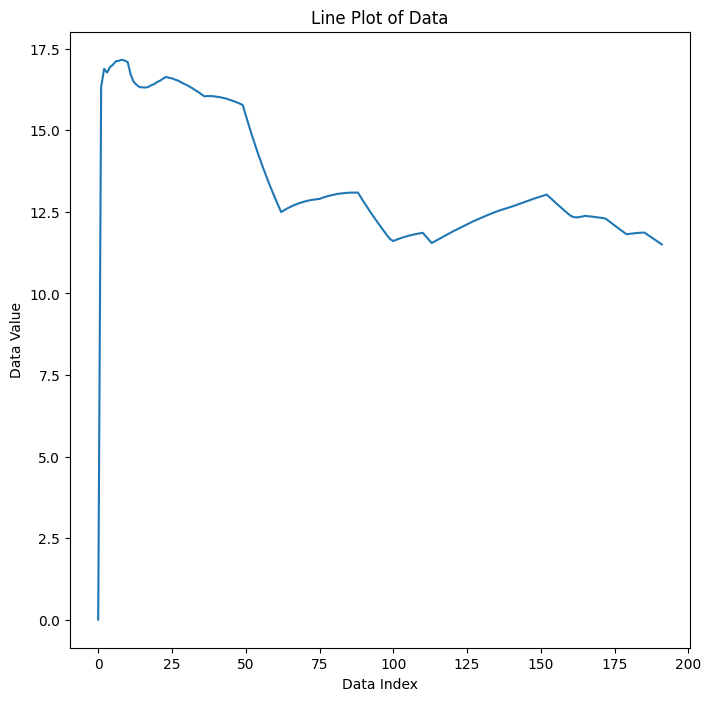

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(measured_value)
ax.set_xlabel('Data Index')
ax.set_ylabel('Data Value')
ax.set_title('Line Plot of Data')
plt.show()

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(predicted_value)
ax.set_xlabel('Data Index')
ax.set_ylabel('Data Value')
ax.set_title('Line Plot of Data')
plt.show()

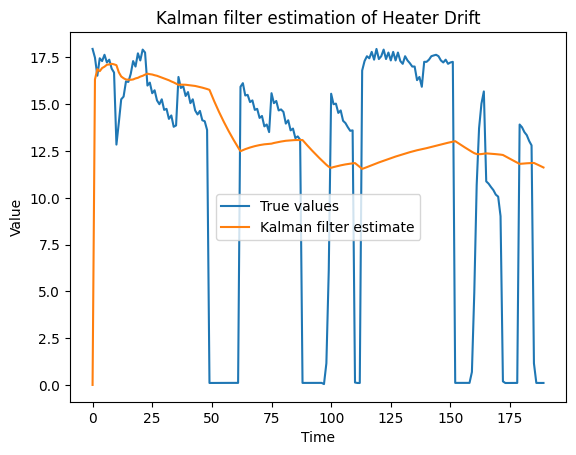

In [ ]:
t = np.arange(0, 190, 1)
plt.plot(t, measured_value[0:190], label='True values')
plt.plot(t, predicted_value[0:190], label='Kalman filter estimate')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Kalman filter estimation of Heater Drift')


plt.show()

In [ ]:
# Define the Kalman filter parameters
dt = 0.3  # time step
A = np.array([[1, dt], [0, 1]])  # state transition matrix
H = np.array([[1, 0]])  # observation matrix
Q = np.array([[1e-3, 0], [0, 1e-3]])  # process noise covariance matrix
R = np.array([[1e-1]])  # measurement noise covariance matrix
x0 = np.array([[0], [0]])  # initial state estimate
P0 = np.array([[1, 0], [0, 1]])  # initial error covariance estimate

# Create the Kalman filter object
kalman_filter = SensorDriftDetector(A, H, Q, R, x0, P0)

predicted_value = []
measured_value = []
# Loop over the rows of the dataset
for i in range(len(df)):
    # Get the sensor measurement vector
    z = np.array(df.iloc[i, 16:17])
    # Detect drift using the Kalman filter
    residual, predicted = kalman_filter.detect_drift(z)
    predicted_value.append(float(predicted))
    measured_value.append(z)

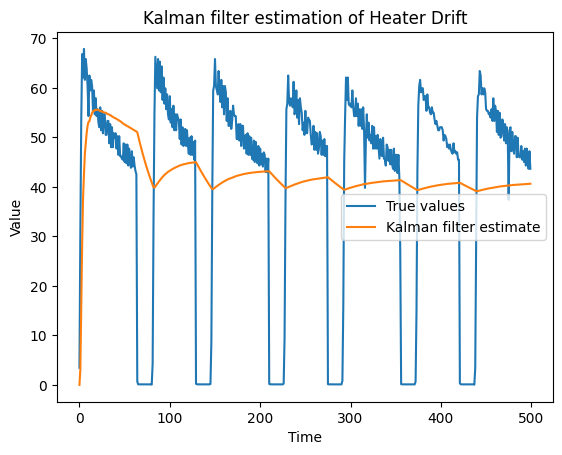

In [ ]:
t = np.arange(0, 500, 1)
plt.plot(t, measured_value[0:500], label='True values')
plt.plot(t, predicted_value[0:500], label='Kalman filter estimate')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Kalman filter estimation of Heater Drift')


plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


# Preprocessing
data = df_heater['R11 (MOhm)'].values.reshape(-1, 1)  # Assuming you're using a single column as input
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define the window size for the LSTM model
window_size = 10

# Create the training dataset
X_train = []
y_train = []
for i in range(window_size, len(scaled_data)):
    X_train.append(scaled_data[i-window_size:i, 0])
    y_train.append(scaled_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Make predictions on the training data
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)

# Compute the absolute errors
errors = np.abs(data[window_size:] - train_predictions)

# Set a threshold for drift detection
threshold = 0.5  # Adjust according to your specific dataset and requirements

# Detect drift
drift_indices = np.where(errors > threshold)[0]

# Print the indices of detected drift points
print("Drift points indices:", drift_indices)

Epoch 1/50
6/6 [==============================] - 6s 17ms/step - loss: 0.3487
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 0.1431
Epoch 3/50
6/6 [==============================] - 0s 15ms/step - loss: 0.1485
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 0.1191
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.1215
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 0.1155
Epoch 7/50
6/6 [==============================] - 0s 18ms/step - loss: 0.1129
Epoch 8/50
6/6 [==============================] - 0s 15ms/step - loss: 0.1079
Epoch 9/50
6/6 [==============================] - 0s 15ms/step - loss: 0.1050
Epoch 10/50
6/6 [==============================] - 0s 14ms/step - loss: 0.1035
Epoch 11/50
6/6 [==============================] - 0s 15ms/step - loss: 0.1016
Epoch 12/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0969
Epoch 13/50
6/6 [==============================] - 0s 15ms/st

Epoch 1/10
12/12 [==============================] - 3s 9ms/step - loss: 0.3419
Epoch 2/10
12/12 [==============================] - 0s 9ms/step - loss: 0.1408
Epoch 3/10
12/12 [==============================] - 0s 9ms/step - loss: 0.1148
Epoch 4/10
12/12 [==============================] - 0s 11ms/step - loss: 0.1054
Epoch 5/10
12/12 [==============================] - 0s 8ms/step - loss: 0.1012
Epoch 6/10
12/12 [==============================] - 0s 8ms/step - loss: 0.0967
Epoch 7/10
12/12 [==============================] - 0s 8ms/step - loss: 0.0933
Epoch 8/10
12/12 [==============================] - 0s 8ms/step - loss: 0.0890
Epoch 9/10
12/12 [==============================] - 0s 8ms/step - loss: 0.0859
Epoch 10/10
6/6 [==============================] - 1s 5ms/step
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  44  45  46  47  48  49  50  51  52  53  54
  57  

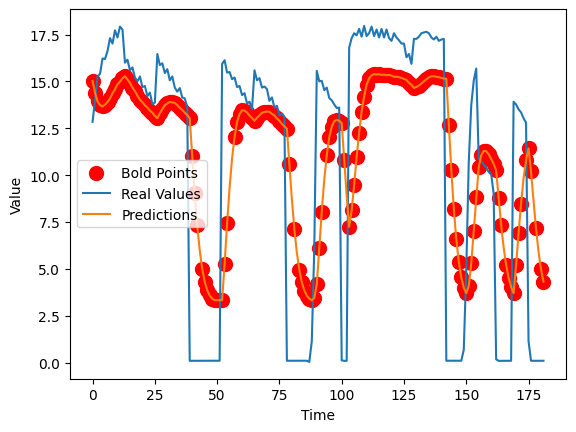

In [ ]:
# Extract the feature(s) to be used for drift detection
data = df_heater['R11 (MOhm)'].values  # Replace 'feature' with the name of your feature column

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

# Define the window size for input sequences
window_size = 10  # Adjust the window size as needed

# Prepare the input sequences
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        window = data[i : i + window_size]
        X.append(window)
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(data, window_size)

# Reshape the input data for LSTM model (samples, time steps, features)
X = np.reshape(X, (X.shape[0], window_size, 1))

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(32, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
model.fit(X, y, epochs=10, batch_size=16, verbose=1)

# Make predictions on the entire dataset
predictions = model.predict(X)

# Inverse transform the scaled data to get the original values
predictions = scaler.inverse_transform(predictions)
y = scaler.inverse_transform(y)

# Bold specific points in the predictions

print(drift_indices)
bold_predictions = [predictions[i] for i in drift_indices]
plt.scatter(drift_indices, bold_predictions, color='red', marker='o', s=100, label='Bold Points')



# Plot the predicted values versus the real values
plt.plot(y, label='Real Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

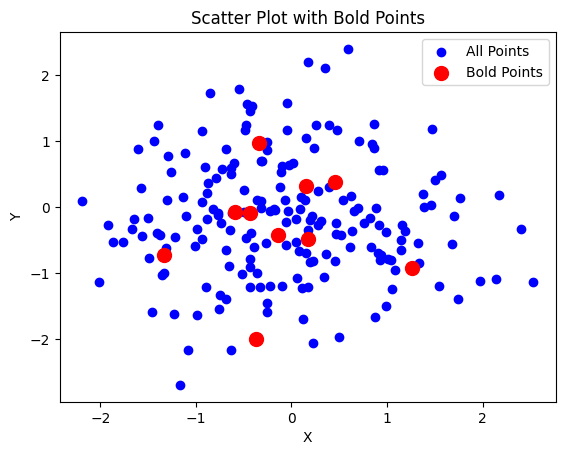

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data
x = np.random.randn(200)
y = np.random.randn(200)

# Plot all points
plt.scatter(x, y, color='blue', label='All Points')

# Bold 10 points
bold_indices = np.random.choice(200, size=10, replace=False)  # Randomly select 10 indices
bold_x = x[bold_indices]
bold_y = y[bold_indices]
plt.scatter(bold_x, bold_y, color='red', marker='o', s=100, label='Bold Points')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Bold Points')
plt.legend()

# Display the plot
plt.show()

Epoch 1/10
51/51 [==============================] - 3s 8ms/step - loss: 0.2097
Epoch 2/10
51/51 [==============================] - 0s 7ms/step - loss: 0.0278
Epoch 3/10
51/51 [==============================] - 0s 8ms/step - loss: 0.0275
Epoch 4/10
51/51 [==============================] - 1s 11ms/step - loss: 0.0276
Epoch 5/10
51/51 [==============================] - 1s 10ms/step - loss: 0.0273
Epoch 6/10
51/51 [==============================] - 0s 9ms/step - loss: 0.0268
Epoch 7/10
51/51 [==============================] - 0s 8ms/step - loss: 0.0267
Epoch 8/10
51/51 [==============================] - 0s 9ms/step - loss: 0.0262
Epoch 9/10
51/51 [==============================] - 0s 7ms/step - loss: 0.0260
Epoch 10/10
26/26 [==============================] - 1s 3ms/step


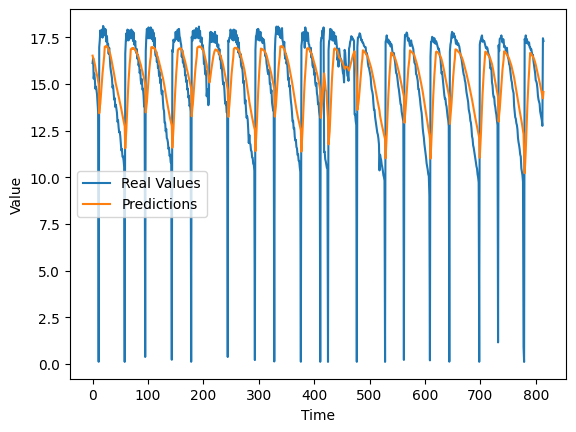

In [ ]:
# Extract the feature(s) to be used for drift detection
data = df_temp['R11 (MOhm)'].values  # Replace 'feature' with the name of your feature column

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

# Define the window size for input sequences
window_size = 10  # Adjust the window size as needed

# Prepare the input sequences
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        window = data[i : i + window_size]
        X.append(window)
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(data, window_size)

# Reshape the input data for LSTM model (samples, time steps, features)
X = np.reshape(X, (X.shape[0], window_size, 1))

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(32, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
model.fit(X, y, epochs=10, batch_size=16, verbose=1)

# Make predictions on the entire dataset
predictions = model.predict(X)

# Inverse transform the scaled data to get the original values
predictions = scaler.inverse_transform(predictions)
y = scaler.inverse_transform(y)

# Plot the predicted values versus the real values
plt.plot(y, label='Real Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

Epoch 1/10
18482/18482 [==============================] - 175s 9ms/step - loss: 0.0022
Epoch 2/10
18482/18482 [==============================] - 164s 9ms/step - loss: 0.0016
Epoch 3/10
18482/18482 [==============================] - 163s 9ms/step - loss: 0.0015
Epoch 4/10
18482/18482 [==============================] - 168s 9ms/step - loss: 0.0015
Epoch 5/10
18482/18482 [==============================] - 167s 9ms/step - loss: 0.0015
Epoch 6/10
18482/18482 [==============================] - 167s 9ms/step - loss: 0.0015
Epoch 7/10
18482/18482 [==============================] - 164s 9ms/step - loss: 0.0015
Epoch 8/10
18482/18482 [==============================] - 167s 9ms/step - loss: 0.0015
Epoch 9/10
18482/18482 [==============================] - 168s 9ms/step - loss: 0.0015
Epoch 10/10
9241/9241 [==============================] - 33s 4ms/step


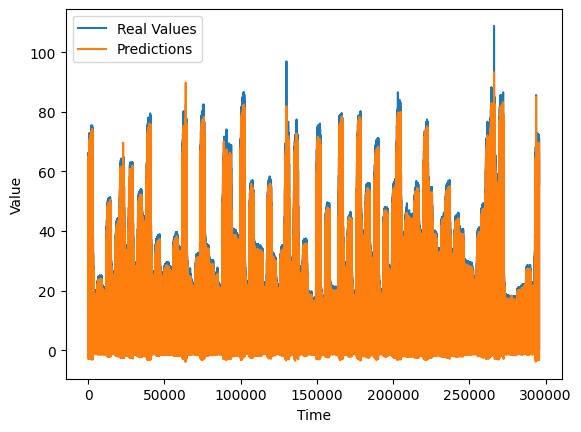

In [ ]:
# Extract the feature(s) to be used for drift detection
data = df['R11 (MOhm)'].values  # Replace 'feature' with the name of your feature column

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

# Define the window size for input sequences
window_size = 10  # Adjust the window size as needed

# Prepare the input sequences
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        window = data[i : i + window_size]
        X.append(window)
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(data, window_size)

# Reshape the input data for LSTM model (samples, time steps, features)
X = np.reshape(X, (X.shape[0], window_size, 1))

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(32, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
model.fit(X, y, epochs=10, batch_size=16, verbose=1)

# Make predictions on the entire dataset
predictions = model.predict(X)

# Inverse transform the scaled data to get the original values
predictions = scaler.inverse_transform(predictions)
y = scaler.inverse_transform(y)

# Plot the predicted values versus the real values
plt.plot(y, label='Real Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()